In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numba
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.optimize import minimize,least_squares,dual_annealing,differential_evolution
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #正常显示负号
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [4]:
def sabr_vector(F,alpha,beta,v,rho,K,T):  #支持向量化计算的代码
    """
    F:当前远期价格
    alpha：F的波动率初始值
    beta：决定F的分布，可经验设置为0,0.5或1，也可当参数拟合
    v：波动率的波动率
    rho:相关系数
    K：行权价
    T；剩余期限
    """
    z = v/alpha * (F*K)**((1-beta)/2) * np.log(F/K)
    xz = np.log( (np.sqrt(1-2*rho*z+z**2)+z-rho) / (1-rho)  )

    first_term = alpha / (  
                            (F*K)**((1-beta)/2)  *    \
                            (1 + (1-beta)**2/24 * np.log(F/K)**2 + (1-beta)**4/1920 * np.log(F/K)**4)   \
                             )
    second_term =  1 + T* (                                                    \
                            (1-beta)**2/24 * alpha**2 / (F*K)**(1-beta)   +    \
                            1/4* rho*beta*v*alpha / (F*K)**((1-beta)/2)   +    \
                            (2-3*rho**2)/24*v**2                               \
                             )
    #其实F=K的时候就是少了z/xz这一项而已，如果用if判断，那么无法向量化计算，对速度影响很大,
    # 此外下面用了np.close取代==判断，防止浮点数==判断不准确的情况
    bs_sigma = np.where(np.isclose(F,K,rtol = 0,atol=0.1**6),first_term * second_term,first_term * second_term * z/xz)  
    return bs_sigma

In [6]:
sabr_vector(F =100,alpha = 0.15,beta = 0.8,v=0.2,rho=-0.2,K=90,T=1)

array(0.0636519)

In [7]:
def sabr_obloj(F,alpha,beta,v,rho,K,T):
    """
    F:当前远期价格
    alpha：F的波动率初始值
    beta：决定F的分布，可经验设置为0,0.5或1，也可当参数拟合
    v：波动率的波动率
    rho:相关系数
    K：行权价
    T；剩余期限
    obloj对hagan的解做了修正，对beta=0和F=K的特殊情况进行了改良，解决了beta趋近于1时的内部矛盾问题，优化了长期限和行权价格较小时的解的精度
    """
    #对于beta为1或者不为0的情况需要特别处理
    if beta == 1:
        z = v* np.log(F/K)/alpha
    else:
        z = v/alpha * (F**(1-beta)-K**(1-beta))/(1-beta)
    
    xz = np.log( (np.sqrt(1-2*rho*z+z**2)+z-rho) / (1-rho)  )

    first_term_F_eq_K = alpha / F**(1-beta)
    first_term_F_ineq_K = v * np.log(F/K) / xz
    first_term = np.where(np.isclose(F,K,rtol = 0,atol=0.1**6),first_term_F_eq_K, first_term_F_ineq_K)  #对于beta为1或者不为0的情况需要特别处理

    
    # second_term和SABR原文hagan解是保持一致的
    second_term =  1 + T* (                                                    \
                            (1-beta)**2/24 * alpha**2 / (F*K)**(1-beta)   +    \
                            1/4* rho*beta*v*alpha / (F*K)**((1-beta)/2)   +    \
                            (2-3*rho**2)/24*v**2                               \
                             )
    bs_sigma = first_term * second_term
    return bs_sigma

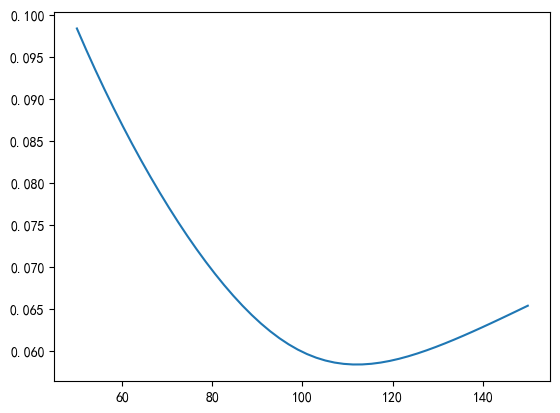

In [8]:
K = np.linspace(50,150,50)
sigma_obloj = sabr_obloj(F =100,alpha = 0.15,beta = 0.8,v=0.2,rho=-0.2,K=K,T=1)
plt.plot(K,sigma_obloj)

In [9]:
data_raw = pd.read_pickle("data/sse50_option_data_processed_20231110.pkl")
data_raw = data_raw.sort_values(["contract_month","exerciseprice"])

In [10]:
data_raw

,date,tradecode,exerciseprice,close,settlement_price,S0,contract_month,CP,实虚值,last_day,maturity,r,F,q,market_imp_vol
80,2023-11-10,510050C2311M02250,2.25,0.2420,0.2420,2.49,2311,0,实值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,NaN
82,2023-11-10,510050P2311M02250,2.25,0.0002,0.0002,2.49,2311,1,虚值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,0.184617
81,2023-11-10,510050C2311M02300,2.30,0.1912,0.1912,2.49,2311,0,实值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,NaN
83,2023-11-10,510050P2311M02300,2.30,0.0003,0.0003,2.49,2311,1,虚值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,0.156664
78,2023-11-10,510050C2311M02350,2.35,0.1433,0.1433,2.49,2311,0,实值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,0.137044
79,2023-11-10,510050P2311M02350,2.35,0.0010,0.0010,2.49,2311,1,虚值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,0.143891
60,2023-11-10,510050C2311M02400,2.40,0.0950,0.0950,2.49,2311,0,实值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,0.121253
69,2023-11-10,510050P2311M02400,2.40,0.0027,0.0027,2.49,2311,1,虚值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,0.124843
61,2023-11-10,510050C2311M02450,2.45,0.0523,0.0523,2.49,2311,0,实值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,0.116273
70,2023-11-10,510050P2311M02450,2.45,0.0101,0.0101,2.49,2311,1,虚值,2023-11-22,0.049587,0.0203,2.492693,-0.001496,0.118823


{'alpha': np.float64(0.11295983049113428), 'beta': 1, 'rho': np.float64(0.12360171507466049), 'v': np.float64(3.1112895589090703)}
{'alpha': np.float64(0.11779297232003105), 'beta': 1, 'rho': np.float64(0.13086104653004121), 'v': np.float64(1.451053743121677)}
{'alpha': np.float64(0.1239187945087536), 'beta': 1, 'rho': np.float64(0.10377484804044608), 'v': np.float64(0.7272882018240425)}
{'alpha': np.float64(0.12807737701271066), 'beta': 1, 'rho': np.float64(0.07946375745990696), 'v': np.float64(0.4252205678853773)}


{'alpha': 0.12807738919785866,
 'beta': 1,
 'rho': 0.07946307028937802,
 'v': 0.42521944864015193}

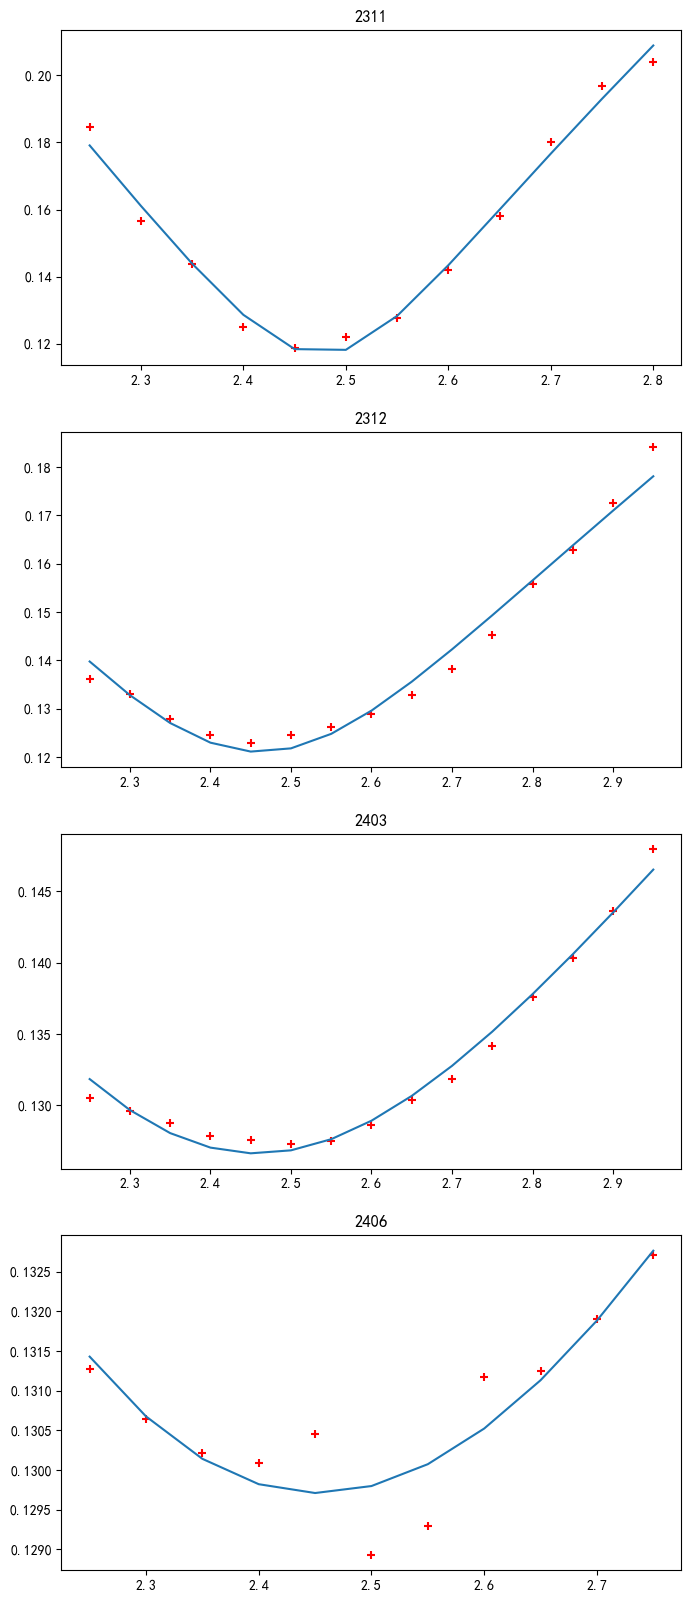

In [11]:
class SABR_obloj:
    def __init__(self,F,K,T,imp_vol,opt_paras):
        self.F = F
        self.K = K
        self.x = np.log(K/F)  #远期在值程度
        self.T = T  #到期时间
        self.imp_vol = imp_vol  #隐含波动率
        
        #opt_paras：优化的alpha,rho,v参数，需要字典形式如，{"alpha":0.0005,"beta":1,"rho":-0.005,"v":0.01},这里加上beta作为可变的
        self.opt_paras = opt_paras
    
    
    #实现定义好SABR的函数,就是前面定义过的函数,参数保留要优化的alpha,v,rho，方便后面代码实现
    def sabr_obloj_func(self,K,alpha,v,rho):

        F,beta,T = self.F,self.opt_paras["beta"],self.T
        
        #对于beta为1或者不为0的情况需要特别处理
        if beta == 1:
            z = v* np.log(F/K)/alpha
        else:
            z = v/alpha * (F**(1-beta)-K**(1-beta))/(1-beta)

        xz = np.log( (np.sqrt(1-2*rho*z+z**2)+z-rho) / (1-rho)  )

        first_term_F_eq_K = alpha / F**(1-beta)
        first_term_F_ineq_K = v * np.log(F/K) / xz
        first_term = np.where(np.isclose(F,K,rtol = 0,atol=0.1**6),first_term_F_eq_K, first_term_F_ineq_K)  #对于beta为1或者不为0的情况需要特别处理


        # second_term和SABR原文hagan解是保持一致的
        second_term =  1 + T* (                                                    \
                                (1-beta)**2/24 * alpha**2 / (F*K)**(1-beta)   +    \
                                1/4* rho*beta*v*alpha / (F*K)**((1-beta)/2)   +    \
                                (2-3*rho**2)/24*v**2                               \
                                 )
        bs_sigma = first_term * second_term
        return bs_sigma 
    
    
    def transform(self,y,l,u):
        return 0.5*( (u+l)+(u-l)*np.tanh(y) )
    
    
    def obj_func(self,x):
        y1,y2,y3 = x
        #transform后才是真正的alpha,v,rho
        alpha,v,rho = self.transform(y1,0,1),self.transform(y2,0,10),self.transform(y3,-1,1)

        err = self.sabr_obloj_func(self.K,alpha,v,rho) - self.imp_vol
        
        return err
    
    def fit(self):
        x0 = (-1,-2.5,0.05) #初始值设定，这边就简单直接设定具体的值，可以根据transform的前后的值大概选取一个经验值
        result = least_squares(self.obj_func,x0,method = "lm",verbose=0).x
        alpha,v,rho = self.transform(result[0],0,1),self.transform(result[1],0,10),self.transform(result[2],-1,1)
        self.opt_paras["alpha"],self.opt_paras["v"],self.opt_paras["rho"] = alpha,v,rho
        print(self.opt_paras)
        return 
    
    def predict(self,K,output):
        
        sabr_imp_vol = self.sabr_obloj_func(K,self.opt_paras["alpha"],self.opt_paras["v"],self.opt_paras["rho"])
        sabr_w = sabr_imp_vol**2 * self.T
        # 一般输出的是隐含波动率，不过有时候输出总方差也会更方便
        if output == "w":
            return sabr_w
        elif output == "imp_vol":
            return sabr_imp_vol

class sabr_surface:
    def __init__(self,data,opt_method):
        self.data = data
        self.opt_method = opt_method
    def get_fit_curve(self):
        fit_result =  []
        
        #循环每个月份，获得相应的拟合函数，返回一个包含svi实例的列表
        for month in self.data["contract_month"].unique():
            fit_option = self.data[(self.data["实虚值"]=="虚值")&(self.data["contract_month"]== month)]
            F = fit_option["F"].values[0]
            K = fit_option["exerciseprice"].values
            T = fit_option["maturity"].values[0]
            imp_vol = fit_option["market_imp_vol"].values
            opt_paras = {"alpha":0.05,"beta":1,"rho":-0.05,"v":0.01}  #先大概指定个初始值，除beta外后续会变化为最优解
            sabr = self.opt_method(F,K,T,imp_vol,opt_paras)
            sabr.fit()
            fit_result.append(sabr)

        return fit_result
    
    def plot_fit_curve(self):
        fit_result =  self.get_fit_curve()
        fig,ax = plt.subplots(nrows=len(self.data["contract_month"].unique()),ncols=1,figsize = (8,20))
        for i,month in enumerate(self.data["contract_month"].unique()):
            fit_option = self.data[(self.data["实虚值"]=="虚值")&(self.data["contract_month"]== month)]
            sabr = fit_result[i]
            fit_option["sabr_vol"] = sabr.predict(sabr.K,output="imp_vol")
            
            ax[i].scatter(x = fit_option["exerciseprice"],y=fit_option["market_imp_vol"],marker = '+',c = "r")
            ax[i].plot(fit_option["exerciseprice"],fit_option["sabr_vol"])
            ax[i].set_title(month)
    
    
    #  根据拟合的SABR函数，和平远期插值，生成100*100的隐含波动率网格
    def gen_imp_vol_grid(self):
        x = np.log(self.data["exerciseprice"]/self.data["F"])
        t_array = np.linspace(self.data["maturity"].min(),self.data["maturity"].max(),100)
        x_array =  np.linspace(x.min(),x.max(),100)
        t, x = np.meshgrid(t_array,x_array) 
        
        # 计算4个期限上的SABR拟合的总方差，并存储在100*4的矩阵里
        fit_result =  self.get_fit_curve()
        w = np.zeros((100,len(fit_result))) 
        
        for m in range(len(fit_result)):
            F_list= self.data["F"].unique()
            K =  F_list[m] * np.exp(x_array) # SABR需要用行权价而不是在值程度，这里返回求解K
            w[:,m] = fit_result[m].predict(K,output="w")
        
        # 在x的维度上循环100次，每次循环在t维度上平远期插值计算
        v = np.zeros_like(t)
        
        for n in range(100):
            f = interp1d(x =self.data["maturity"].unique(),y =w[n],kind = "linear")
            v[n] = np.sqrt(f(t[n])/t[n])  #返回的还是隐含波动率而不是总方差

        return t,x,v
    
    def plot_surface(self):
        fig = plt.figure(figsize=(12, 7))
        ax = plt.axes(projection='3d')
        norm = mpl.colors.Normalize(vmin=0.1, vmax=0.2)
        # 绘图主程序
        t,x,v = self.gen_imp_vol_grid()
        surf = ax.plot_surface(t, x, v, rstride=1, cstride=1,
        cmap=plt.cm.coolwarm,norm = norm,linewidth=0.5, antialiased=True)
        # 设置坐标轴
        ax.set_xlabel('maturity')
        ax.set_ylabel('strike')
        ax.set_zlabel('market_imp_vol')
        ax.set_zlim((0.1,0.25))
        fig.colorbar(surf, shrink=0.25, aspect=5)

sabr_fit = sabr_surface(data = data_raw,opt_method=SABR_obloj)

sabr_fit.plot_fit_curve()

{'alpha': 0.11295983141571708, 'beta': 1, 'rho': 0.12360170030565441, 'v': 3.1112895133248886}
{'alpha': 0.11779297828496132, 'beta': 1, 'rho': 0.1308614042534911, 'v': 1.4510533654947921}
{'alpha': 0.12391879495970315, 'beta': 1, 'rho': 0.10377486888707423, 'v': 0.72728817397567}
{'alpha': 0.12807738919785866, 'beta': 1, 'rho': 0.07946307028937802, 'v': 0.42521944864015193}

{'alpha': np.float64(0.11295983049113428), 'beta': 1, 'rho': np.float64(0.12360171507466049), 'v': np.float64(3.1112895589090703)}
{'alpha': np.float64(0.11779297232003105), 'beta': 1, 'rho': np.float64(0.13086104653004121), 'v': np.float64(1.451053743121677)}
{'alpha': np.float64(0.1239187945087536), 'beta': 1, 'rho': np.float64(0.10377484804044608), 'v': np.float64(0.7272882018240425)}
{'alpha': np.float64(0.12807737701271066), 'beta': 1, 'rho': np.float64(0.07946375745990696), 'v': np.float64(0.4252205678853773)}


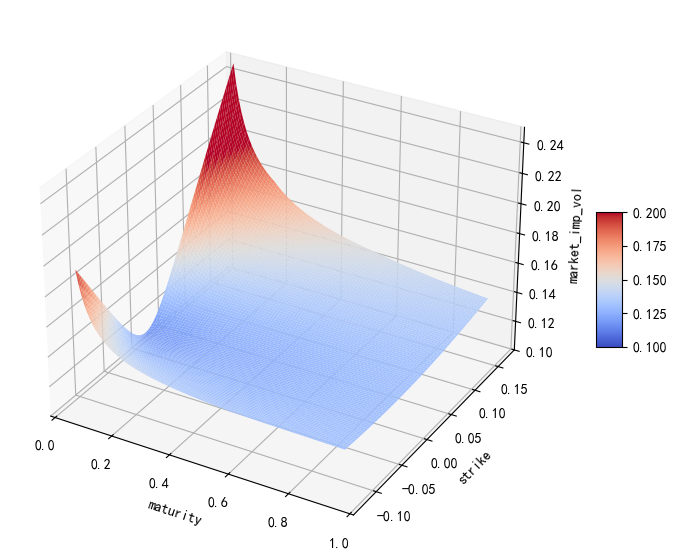

In [12]:
sabr_fit.plot_surface()